# ufunc_reduce_all_i4
This notebook will build two modules in which the overlay is controlled using pybind11 and CFFI respectively. The `.so` files will be copied into the `zypy/lib/` folder so they can be used with ZyPy. The generic initalisation code is found below. After that, four implementatiations will be made and compared: the default NumPy one, the hardware accelerated version using PYNQ, the hardware accelerated version using pybind11 and the hardware accelerated version using CFFI. A timing analysis at the end will reveal the minimum stream size required for the accelerators to be more beneficial than the default NumPy implementation. To build and do the analysis, click on `Kernel > Restart & Run All`.

In [1]:
from pynq import Overlay, allocate
import numpy as np

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_i4.bit")

N = 10_000

x1 = allocate(shape=(N), dtype="i4")
x2 = allocate(shape=(N), dtype="i4")
out = allocate(shape=(N), dtype="i4")

x1[:] = np.random.rand(*x1.shape) + 1
x2[:] = np.random.rand(*x1.shape) + 1
out[:] = np.zeros(out.shape)

# NumPy
This is just a wrapper around the default NumPy implementation. The wrapper is required so we can compare it in the timing analysis.

In [2]:
def add_reduce_all_i4_numpy(x1):
    return np.add.reduce(x1, axis = None)

def subtract_reduce_all_i4_numpy(x1):
    return np.subtract.reduce(x1, axis = None)

def multiply_reduce_all_i4_numpy(x1):
    return np.multiply.reduce(x1, axis = None)

def dot_i4_numpy(x1, x2):
    return np.dot(x1, x2)

def sum_of_squares_i4_numpy(x1):
    return np.sum(x1 ** 2)

def sad_i4_numpy(x1, x2):
    return np.add.reduce(np.absolute(x1 - x2), axis = None)

out[:] = 0
print(f"add_reduce_all_i4_numpy = {add_reduce_all_i4_numpy(x1)}")

out[:] = 0
print(f"subtract_reduce_all_i4_numpy = {subtract_reduce_all_i4_numpy(x1)}")

out[:] = 0
print(f"multiply_reduce_all_i4_numpy = {multiply_reduce_all_i4_numpy(x1)}")

out[:] = 0
print(f"dot_i4_numpy = {dot_i4_numpy(x1, x2)}")

out[:] = 0
print(f"sum_of_squares_i4_numpy = {sum_of_squares_i4_numpy(x1)}")

out[:] = 0
print(f"sad_i4_numpy = {sad_i4_numpy(x1, x2)}")

add_reduce_all_i4_numpy = 10000
subtract_reduce_all_i4_numpy = -9998
multiply_reduce_all_i4_numpy = 1
dot_i4_numpy = 10000
sum_of_squares_i4_numpy = 10000
sad_i4_numpy = 0


# PYNQ
This is the default PYNQ implementation, in which the AXI4-Lite registers are controlled using the built-in MMIO module.

In [3]:
from struct import pack, unpack
import numpy as np

NONE = 0
ADD = 1
MULTIPLY = 2
SQUARE = 3
EXP = 4
LOG = 5
ABSDIFF = 6
SUBTRACT = 7
TRUE_DIVIDE = 8
SIN = 9
SQRT = 10
ARCTAN = 11
SINH = 12

def add_reduce_all_i4_pynq(x1):
    overlay.ufunc_reduce_all_i4_0.mmio.write(0x18, (ADD << 0) | (NONE << 8) | (NONE << 16))  # Set the args
    overlay.ufunc_reduce_all_i4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    while not (overlay.ufunc_reduce_all_i4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_i4_0.mmio.read(0x10)

    return out

def subtract_reduce_all_i4_pynq(x1):
    overlay.ufunc_reduce_all_i4_0.mmio.write(0x18, (ADD << 0) | (NONE << 8) | (NONE << 16))  # Set the args
    overlay.ufunc_reduce_all_i4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1, start=4)
    while not (overlay.ufunc_reduce_all_i4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_i4_0.mmio.read(0x10)

    return x1.flat[0] - out

def multiply_reduce_all_i4_pynq(x1):
    overlay.ufunc_reduce_all_i4_0.mmio.write(0x18, (MULTIPLY << 0) | (NONE << 8) | (NONE << 16))  # Set the args
    overlay.ufunc_reduce_all_i4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    while not (overlay.ufunc_reduce_all_i4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_i4_0.mmio.read(0x10)

    return out

def dot_i4_pynq(x1, x2):
    overlay.ufunc_reduce_all_i4_0.mmio.write(0x18, (ADD << 0) | (MULTIPLY << 8) | (NONE << 16))  # Set the args
    overlay.ufunc_reduce_all_i4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    while not (overlay.ufunc_reduce_all_i4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_i4_0.mmio.read(0x10)

    return out

def sum_of_squares_i4_pynq(x1):
    overlay.ufunc_reduce_all_i4_0.mmio.write(0x18, (ADD << 0) | (SQUARE << 8) | (NONE << 16))  # Set the args
    overlay.ufunc_reduce_all_i4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    while not (overlay.ufunc_reduce_all_i4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_i4_0.mmio.read(0x10)

    return out

def sad_i4_pynq(x1, x2):
    overlay.ufunc_reduce_all_i4_0.mmio.write(0x18, (ADD << 0) | (ABSDIFF << 8) | (NONE << 16))  # Set the args
    overlay.ufunc_reduce_all_i4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    while not (overlay.ufunc_reduce_all_i4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_i4_0.mmio.read(0x10)

    return out

out[:] = 0
print(f"add_reduce_all_i4_pynq = {add_reduce_all_i4_pynq(x1)}")

out[:] = 0
print(f"subtract_reduce_all_i4_pynq = {subtract_reduce_all_i4_pynq(x1)}")

out[:] = 0
print(f"multiply_reduce_all_i4_pynq = {multiply_reduce_all_i4_pynq(x1)}")

out[:] = 0
print(f"dot_i4_pynq = {dot_i4_pynq(x1, x2)}")

out[:] = 0
print(f"sum_of_squares_i4_pynq = {sum_of_squares_i4_pynq(x1)}")

out[:] = 0
print(f"sad_i4_pynq = {sad_i4_pynq(x1, x2)}")

add_reduce_all_i4_pynq = 10000
subtract_reduce_all_i4_pynq = -9998
multiply_reduce_all_i4_pynq = 1
dot_i4_pynq = 10000
sum_of_squares_i4_pynq = 10000
sad_i4_pynq = 0


# pybind11
This is the pybind11 implementation, in which all registers are controlled by `mmap`ing the physical memory `/dev/mem/`.

In [4]:
%%pybind11 ufunc_reduce_all_i4_pybind11

#include "defines.h"

#define NONE 0
#define ADD 1
#define MULTIPLY 2
#define SQUARE 3
#define EXP 4
#define LOG 5
#define ABSDIFF 6
#define SUBTRACT 7
#define TRUE_DIVIDE 8
#define SIN 9
#define SQRT 10
#define ARCTAN 11
#define SINH 12

float to_int(unsigned int val) {
    union {
        unsigned int u4;
        int i4;
    } data = {val};

    return data.i4;
}

float add_reduce_all_i4(unsigned int x1_addr, unsigned int nbytes)
{
    init();

    ufunc_reduce_all_i4_0_args_args_w(((ADD << 0) | (NONE << 8) | (NONE << 16)));
    ufunc_reduce_all_i4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    while(!(ufunc_reduce_all_i4_0_ctrl_ap_done_r()));

    float res = to_int(ufunc_reduce_all_i4_0_ap_return_ap_return_r());

    exit();

    return res;
}

float multiply_reduce_all_i4(unsigned int x1_addr, unsigned int nbytes)
{
    init();

    ufunc_reduce_all_i4_0_args_args_w(((MULTIPLY << 0) | (NONE << 8) | (NONE << 16)));
    ufunc_reduce_all_i4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    while(!(ufunc_reduce_all_i4_0_ctrl_ap_done_r()));

    float res = to_int(ufunc_reduce_all_i4_0_ap_return_ap_return_r());

    exit();

    return res;
}

float dot_i4(unsigned int x1_addr, unsigned int x2_addr, unsigned int nbytes)
{
    init();

    ufunc_reduce_all_i4_0_args_args_w(((ADD << 0) | (MULTIPLY << 8) | (NONE << 16)));
    ufunc_reduce_all_i4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_1_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_1_mm2s_dmacr_rs_rw(0x1);
    axi_dma_1_mm2s_sa_source_address_rw(x2_addr);
    axi_dma_1_mm2s_length_length_rw(nbytes);

    while(!(ufunc_reduce_all_i4_0_ctrl_ap_done_r()));

    float res = to_int(ufunc_reduce_all_i4_0_ap_return_ap_return_r());

    exit();

    return res;
}

float sum_of_squares_i4(unsigned int x1_addr, unsigned int nbytes)
{
    init();

    ufunc_reduce_all_i4_0_args_args_w(((ADD << 0) | (SQUARE << 8) | (NONE << 16)));
    ufunc_reduce_all_i4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    while(!(ufunc_reduce_all_i4_0_ctrl_ap_done_r()));

    float res = to_int(ufunc_reduce_all_i4_0_ap_return_ap_return_r());

    exit();

    return res;
}

float sad_i4(unsigned int x1_addr, unsigned int x2_addr, unsigned int nbytes)
{
    init();

    ufunc_reduce_all_i4_0_args_args_w(((ADD << 0) | (ABSDIFF << 8) | (NONE << 16)));
    ufunc_reduce_all_i4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_1_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_1_mm2s_dmacr_rs_rw(0x1);
    axi_dma_1_mm2s_sa_source_address_rw(x2_addr);
    axi_dma_1_mm2s_length_length_rw(nbytes);

    while(!(ufunc_reduce_all_i4_0_ctrl_ap_done_r()));

    float res = to_int(ufunc_reduce_all_i4_0_ap_return_ap_return_r());

    exit();

    return res;
}

In [5]:
# This cell writes the above source code to a file, so that it can be reused for the CFFI implementation.
# Please make sure the cell above is the last cell executed!

with open(f"ufunc_reduce_all_i4.c", "w") as f:
    code = ("#" + _ih[-2].split("#", 1)[1])[:-2].replace("\\n", "\n")
    f.write(code)

In [6]:
import ufunc_reduce_all_i4_pybind11 as calc

def add_reduce_all_i4_pybind11(x1):
    return calc.add_reduce_all_i4(x1.physical_address, x1.nbytes)

def subtract_reduce_all_i4_pybind11(x1):
    return x1.flat[0] - calc.add_reduce_all_i4(x1.physical_address + 4, x1.nbytes - 4)

def multiply_reduce_all_i4_pybind11(x1):
    return calc.multiply_reduce_all_i4(x1.physical_address, x1.nbytes)

def dot_i4_pybind11(x1, x2):
    return calc.dot_i4(x1.physical_address, x2.physical_address, x1.nbytes)

def sum_of_squares_i4_pybind11(x1):
    return calc.sum_of_squares_i4(x1.physical_address, x1.nbytes)

def sad_i4_pybind11(x1, x2):
    return calc.sad_i4(x1.physical_address, x2.physical_address, x1.nbytes)

out[:] = 0
print(f"add_reduce_all_i4_pybind11 = {add_reduce_all_i4_pybind11(x1)}")

out[:] = 0
print(f"subtract_reduce_all_i4_pybind11 = {subtract_reduce_all_i4_pybind11(x1)}")

out[:] = 0
print(f"multiply_reduce_all_i4_pybind11 = {multiply_reduce_all_i4_pybind11(x1)}")

out[:] = 0
print(f"dot_i4_pybind11 = {dot_i4_pybind11(x1, x2)}")

out[:] = 0
print(f"sum_of_squares_i4_pybind11 = {sum_of_squares_i4_pybind11(x1)}")

out[:] = 0
print(f"sad_i4_pybind11 = {sad_i4_pybind11(x1, x2)}")

add_reduce_all_i4_pybind11 = 10000.0
subtract_reduce_all_i4_pybind11 = -9998.0
multiply_reduce_all_i4_pybind11 = 1.0
dot_i4_pybind11 = 10000.0
sum_of_squares_i4_pybind11 = 10000.0
sad_i4_pybind11 = 0.0


# CFFI
This is the CFFI implementation, of which the source code is identical to the pybind11 implementation.
The only thing that needs to be added are the C definitions.

In [7]:
%%writefile build_ufunc_reduce_all_i4_cffi.py

from cffi import FFI
ffibuilder = FFI()

# Add all C definitions below...

ffibuilder.cdef(
    r"""
float add_reduce_all_i4(unsigned int x1_addr, unsigned int nbytes);
float multiply_reduce_all_i4(unsigned int x1_addr, unsigned int nbytes);
float dot_i4(unsigned int x1_addr, unsigned int x2_addr, unsigned int nbytes);
float sum_of_squares_i4(unsigned int x1_addr, unsigned int nbytes);
float sad_i4(unsigned int x1_addr, unsigned int x2_addr, unsigned int nbytes);
    """
)

with open("ufunc_reduce_all_i4.c") as f:
    ffibuilder.set_source("ufunc_reduce_all_i4_cffi", f.read())

if __name__ == "__main__":
    ffibuilder.compile(verbose=True)

Overwriting build_ufunc_reduce_all_i4_cffi.py


In [8]:
%%bash

/home/xilinx/perf_env/bin/python  build_ufunc_reduce_all_i4_cffi.py
cp ufunc_reduce_all_i4_cffi.cpython-37m-arm-linux-gnueabihf.so ../
cp ufunc_reduce_all_i4_pybind11.so ../

generating ./ufunc_reduce_all_i4_cffi.c
the current directory is '/home/xilinx/jupyter_notebooks/zypy/lib/ufunc_reduce_all_i4'
running build_ext
building 'ufunc_reduce_all_i4_cffi' extension
arm-linux-gnueabihf-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/xilinx/perf_env/include -I/usr/include/python3.7m -c ufunc_reduce_all_i4_cffi.c -o ./ufunc_reduce_all_i4_cffi.o
arm-linux-gnueabihf-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./ufunc_reduce_all_i4_cffi.o -o ./ufunc_reduce_all_i4_cffi.cpython-37m-arm-linux-gnueabihf.so


In file included from ufunc_reduce_all_i4_cffi.c:569:0:
defines.h:172:15: warning: backslash-newline at end of file
 #define exit()\
                


In [9]:
from ufunc_reduce_all_i4_cffi import lib as calc

def add_reduce_all_i4_cffi(x1):
    return calc.add_reduce_all_i4(x1.physical_address, x1.nbytes)

def subtract_reduce_all_i4_cffi(x1):
    return x1.flat[0] - calc.add_reduce_all_i4(x1.physical_address + 4, x1.nbytes - 4)

def multiply_reduce_all_i4_cffi(x1):
    return calc.multiply_reduce_all_i4(x1.physical_address, x1.nbytes)

def dot_i4_cffi(x1, x2):
    return calc.dot_i4(x1.physical_address, x2.physical_address, x1.nbytes)

def sum_of_squares_i4_cffi(x1):
    return calc.sum_of_squares_i4(x1.physical_address, x1.nbytes)

def sad_i4_cffi(x1, x2):
    return calc.sad_i4(x1.physical_address, x2.physical_address, x1.nbytes)

out[:] = 0
print(f"add_reduce_all_i4_cffi = {add_reduce_all_i4_cffi(x1)}")

out[:] = 0
print(f"subtract_reduce_all_i4_cffi = {subtract_reduce_all_i4_cffi(x1)}")

out[:] = 0
print(f"multiply_reduce_all_i4_cffi = {multiply_reduce_all_i4_cffi(x1)}")

out[:] = 0
print(f"dot_i4_cffi = {dot_i4_cffi(x1, x2)}")

out[:] = 0
print(f"sum_of_squares_i4_cffi = {sum_of_squares_i4_cffi(x1)}")

out[:] = 0
print(f"sad_i4_cffi = {sad_i4_cffi(x1, x2)}")

add_reduce_all_i4_cffi = 10000.0
subtract_reduce_all_i4_cffi = -9998.0
multiply_reduce_all_i4_cffi = 1.0
dot_i4_cffi = 10000.0
sum_of_squares_i4_cffi = 10000.0
sad_i4_cffi = 0.0


# Timing analysis
The timing analysis is done for each of the functions that is accelerated in hardware. The values of the stream size for which the hardware implementation provides acceleration are given by `pynq_min`, `pybind11_min` and `cffi_min` respectively. Equivalently `pynq_min_reconf`, `pybind11_min_reconf` and `cffi_min_recong` indicate the size required in case reconfiguration is taken into account as well.

## add_reduce_all_i4


kernel = numpy, n = 16, t = 0.00021484650000000002
kernel = pynq, n = 16, t = 0.1296390365
kernel = pybind11, n = 16, t = 0.00028354190000000004
kernel = cffi, n = 16, t = 0.0002560277
kernel = numpy, n = 32, t = 0.0002116797
kernel = pynq, n = 32, t = 0.1289974721
kernel = pybind11, n = 32, t = 0.0002851865
kernel = cffi, n = 32, t = 0.00025584770000000004
kernel = numpy, n = 64, t = 0.0002073959
kernel = pynq, n = 64, t = 0.1290327493
kernel = pybind11, n = 64, t = 0.0003635495
kernel = cffi, n = 64, t = 0.0002581476
kernel = numpy, n = 128, t = 0.00022266920000000003
kernel = pynq, n = 128, t = 0.12980530040000002
kernel = pybind11, n = 128, t = 0.0003001846
kernel = cffi, n = 128, t = 0.000257775
kernel = numpy, n = 256, t = 0.0002379289
kernel = pynq, n = 256, t = 0.1293898592
kernel = pybind11, n = 256, t = 0.00038166790000000007
kernel = cffi, n = 256, t = 0.0002595682
kernel = numpy, n = 512, t = 0.0002697587
kernel = pynq, n = 512, t = 0.1296065754
kernel = pybind11, n = 512, 

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.342790625000000… │ 0.00810243978125  │ 1.772136875000000… │ 1.600173125e-05   │
│ 32      │ 6.614990625e-06    │ 0.004031171003125 │ 8.912078125e-06    │ 7.99524062500000… │
│ 64      │ 3.2405609375e-06   │ 0.00201613670781… │ 5.6804609375e-06   │ 4.03355625e-06    │
│ 128     │ 1.739603125000000… │ 0.00101410390937… │ 2.3451921875e-06   │ 2.0138671875e-06  │
│ 256     │ 9.29409765625e-07  │ 0.0005054291375   │ 1.490890234375000… │ 1.01393828125e-06 │
│ 512     │ 5.268724609375e-07 │ 0.00025313784257… │ 7.417873046875e-07 │ 5.1228046875e-07  │
│ 1024    │ 3.302908203125000… │ 0.00012662804853… │ 2.865868164062500… │ 2.5988642578125e… │
│ 2048    │ 2.153657226562500… │ 6.33838260742187… │ 7.9657763671875e-… │ 1.34897265625e-07 │
│ 4096    │ 1.661687255859375… │ 3.16644924560546… │ 1.008972412109375… │ 7.05461181640625… │
│ 8192    │ 1.367994140625000… │ 1.58443825561523… │ 5.5248876953125e-… │ 4.09021484375000… │
│ 16384   │ 1.244592773437500… │ 7.96979351806640… │ 2.659883422851562… │ 2.54189819335937… │
│ 32768   │ 1.179266906738281… │ 3.96848992004394… │ 2.0831787109375e-… │ 1.69940856933593… │
│ 65536   │ 1.146613906860351… │ 1.99358296661376… │ 1.468992767333984… │ 1.29706375122070… │
│ 131072  │ 1.129867485046386… │ 9.93027365875244… │ 1.118338241577148… │ 1.10465957641601… │
│ 262144  │ 1.126545307159424… │ 4.98023465347290… │ 1.058230400085449… │ 1.05215148925781… │
│ 524288  │ 1.117264619827270… │ 2.49216901588439… │ 1.026969738006591… │ 1.02613649368286… │
│ 1048576 │ 1.111771564483642… │ 1.25420321655273… │ 1.014568738937378… │ 1.02466882705688… │
│ 2097152 │ 1.110717702865600… │ 6.26105725765228… │ 1.007856030464172… │ 1.00816107273101… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

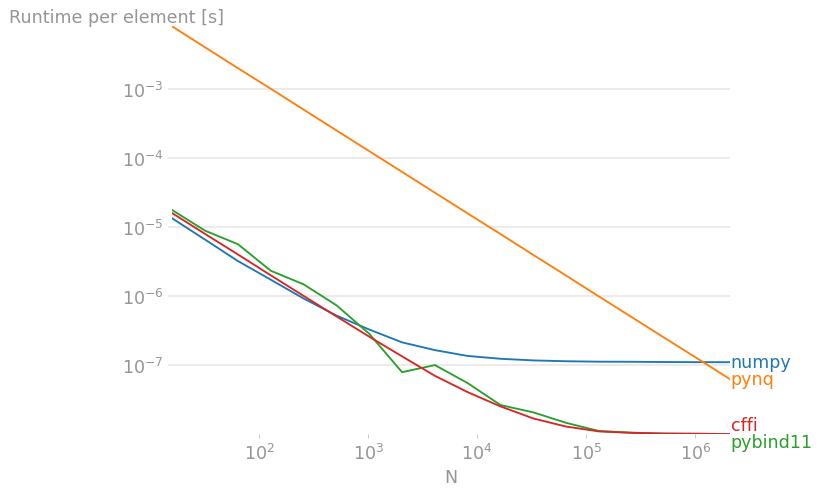

pynq_min = 1048576
pybind11_min = 512
cffi_min = 256
Bitstream download time = 0.222775


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.342790625000000… │ 0.02202587728125  │ 0.01394115886875   │ 0.01393943923125  │
│ 32      │ 6.614990625e-06    │ 0.010992889753125 │ 0.006970630828125  │ 0.006969713990625 │
│ 64      │ 3.2405609375e-06   │ 0.00549699608281… │ 0.0034865398359375 │ 0.00348489293125  │
│ 128     │ 1.739603125000000… │ 0.002754533596875 │ 0.0017427748796875 │ 0.00174244355468… │
│ 256     │ 9.29409765625e-07  │ 0.00137564398125  │ 0.000871705733984… │ 0.00087122878203… │
│ 512     │ 5.268724609375e-07 │ 0.00068824526445… │ 0.000435849209179… │ 0.00043561970234… │
│ 1024    │ 3.302908203125000… │ 0.00034418175947… │ 0.000217840297753… │ 0.00021781359736… │
│ 2048    │ 2.153657226562500… │ 0.00017216068154… │ 0.000108856513232… │ 0.00010891175273… │
│ 4096    │ 1.661687255859375… │ 8.60529201904297… │ 5.448932497558594… │ 5.44589738525390… │
│ 8192    │ 1.367994140625000… │ 4.30385964233398… │ 2.724946274414062… │ 2.7235116015625e… │
│ 16384   │ 1.244592773437500… │ 2.15669004516601… │ 1.362370576782226… │ 1.36225259155273… │
│ 32768   │ 1.179266906738281… │ 1.07670433868408… │ 6.81938525390625e… │ 6.81554755249023… │
│ 65536   │ 1.146613906860351… │ 5.39285970001220… │ 3.413966661071777… │ 3.41224737091064… │
│ 131072  │ 1.129867485046386… │ 2.69266573257446… │ 1.710821749114990… │ 1.71068496246337… │
│ 262144  │ 1.126545307159424… │ 1.34784264869689… │ 8.604014873504638… │ 8.60340698242187… │
│ 524288  │ 1.117264619827270… │ 6.74126493263244… │ 4.351792890548706… │ 4.35170956611633… │
│ 1048576 │ 1.111771564483642… │ 3.37875117492675… │ 2.226004832267761… │ 2.22701484107971… │
│ 2097152 │ 1.110717702865600… │ 1.68837970495224… │ 1.163059582233429… │ 1.16309008646011… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

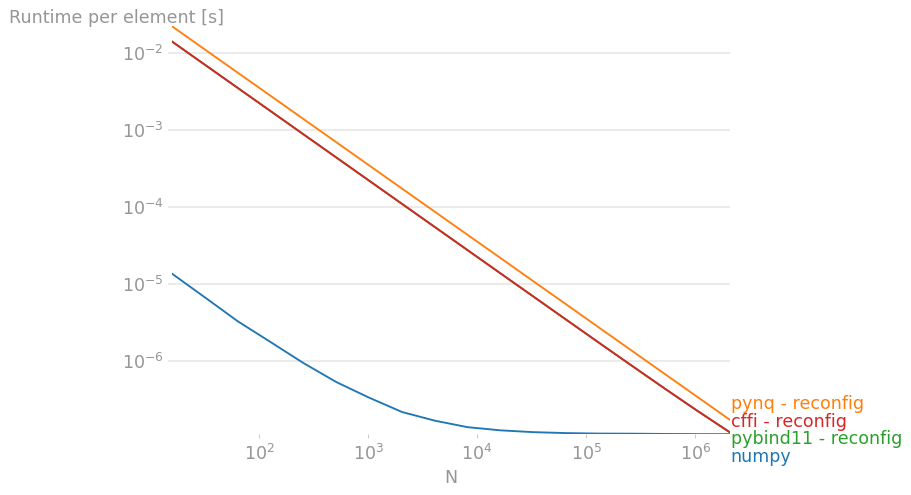

pynq_min_reconf = inf
pybind11_min_reconf = inf
cffi_min_reconf = inf


In [10]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_i4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n,), dtype="i4")

    x1[:] = np.random.rand(*x1.shape)

    return (x1,)

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [add_reduce_all_i4_numpy, add_reduce_all_i4_pynq, add_reduce_all_i4_pybind11, add_reduce_all_i4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_i4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## subtract_reduce_all_i4


kernel = numpy, n = 16, t = 0.0002132314
kernel = pynq, n = 16, t = 0.130383622
kernel = pybind11, n = 16, t = 0.0004833511
kernel = cffi, n = 16, t = 0.00036398370000000004
kernel = numpy, n = 32, t = 0.00022440060000000002
kernel = pynq, n = 32, t = 0.1305881257
kernel = pybind11, n = 32, t = 0.00048429880000000003
kernel = cffi, n = 32, t = 0.00036396990000000005
kernel = numpy, n = 64, t = 0.00021535820000000003
kernel = pynq, n = 64, t = 0.1303182364
kernel = pybind11, n = 64, t = 0.00039474890000000003
kernel = cffi, n = 64, t = 0.00035405850000000004
kernel = numpy, n = 128, t = 0.00021271570000000003
kernel = pynq, n = 128, t = 0.13051944540000002
kernel = pybind11, n = 128, t = 0.00038898370000000005
kernel = cffi, n = 128, t = 0.0003572803
kernel = numpy, n = 256, t = 0.00022768700000000002
kernel = pynq, n = 256, t = 0.13144518230000002
kernel = pybind11, n = 256, t = 0.00039341290000000003
kernel = cffi, n = 256, t = 0.0003745138
kernel = numpy, n = 512, t = 0.0002704184000

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.33269625e-05     │ 0.008148976375    │ 3.020944375e-05    │ 2.27489812500000… │
│ 32      │ 7.012518750000001… │ 0.004080878928125 │ 1.513433750000000… │ 1.13740593750000… │
│ 64      │ 3.364971875000000… │ 0.00203622244375  │ 6.167951562500000… │ 5.53216406250000… │
│ 128     │ 1.661841406250000… │ 0.00101968316718… │ 3.038935156250000… │ 2.79125234375e-06 │
│ 256     │ 8.894023437500001… │ 0.00051345774335… │ 1.536769140625000… │ 1.46294453125e-06 │
│ 512     │ 5.281609375000001… │ 0.00025481733300… │ 7.725750000000001… │ 7.31394140625e-07 │
│ 1024    │ 3.296142578125000… │ 0.00012752479306… │ 4.000318359375e-07 │ 3.584341796875e-… │
│ 2048    │ 2.106702636718750… │ 6.38557180664062… │ 2.021293457031250… │ 1.8388466796875e… │
│ 4096    │ 1.628600341796874… │ 3.19363864501953… │ 1.2788310546875e-… │ 9.78770263671875… │
│ 8192    │ 1.380943481445312… │ 1.59713104736328… │ 5.650875244140625… │ 5.34646850585937… │
│ 16384   │ 1.248160522460937… │ 7.97626918334961… │ 3.267000122070313… │ 3.09362426757812… │
│ 32768   │ 1.182435760498047… │ 4.0032056640625e… │ 2.116422119140625… │ 1.99193481445312… │
│ 65536   │ 1.147057357788086… │ 2.05245626373291… │ 1.707927093505859… │ 1.54291305541992… │
│ 131072  │ 1.176528762817383… │ 1.02851178588867… │ 1.193110580444336… │ 1.17811752319335… │
│ 262144  │ 1.127155124664306… │ 5.00100262451171… │ 1.093039054870605… │ 1.08755023956298… │
│ 524288  │ 1.118581718444824… │ 2.50367659568786… │ 1.050423202514648… │ 1.04719650268554… │
│ 1048576 │ 1.111965612411499… │ 1.25350915527343… │ 1.024152488708496… │ 1.02551844596862… │
│ 2097152 │ 1.110555519104004… │ 6.28949652671814… │ 1.044176230430603… │ 1.01520000934600… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

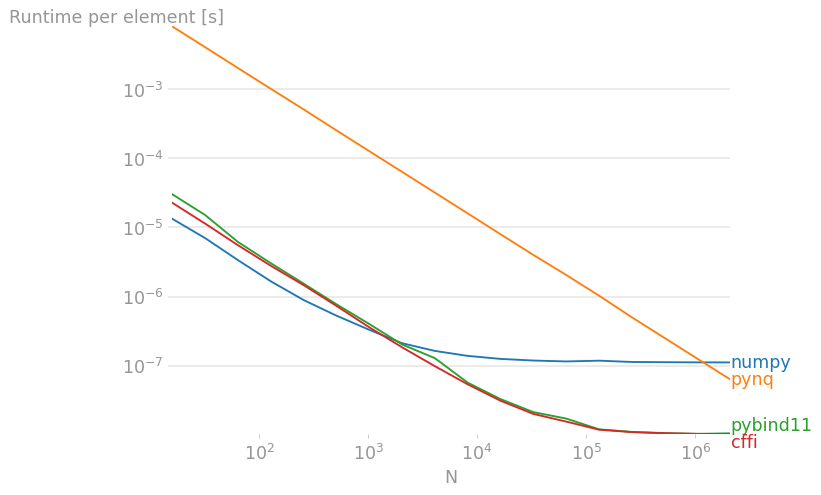

pynq_min = 1048576
pybind11_min = 1024
cffi_min = 1024
Bitstream download time = 0.21847669500000003


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.33269625e-05     │ 0.02180376981250… │ 0.013685002881250… │ 0.01367754241875  │
│ 32      │ 7.012518750000001… │ 0.010908275646875 │ 0.006842531056250… │ 0.00683877077812… │
│ 64      │ 3.364971875000000… │ 0.00544992080312… │ 0.003419866310937… │ 0.00341923052343… │
│ 128     │ 1.661841406250000… │ 0.00272653234687… │ 0.001709888114843… │ 0.00170964043203… │
│ 256     │ 8.894023437500001… │ 0.00136688233320… │ 0.000854961358984… │ 0.00085488753437… │
│ 512     │ 5.281609375000001… │ 0.00068152962792… │ 0.000427484869921… │ 0.00042744368906… │
│ 1024    │ 3.296142578125000… │ 0.00034088094052… │ 0.000213756179296… │ 0.00021371458164… │
│ 2048    │ 2.106702636718750… │ 0.00017053379179… │ 0.000106880203076… │ 0.00010686195839… │
│ 4096    │ 1.628600341796874… │ 8.52754233154296… │ 5.346691997070313… │ 5.34369138916015… │
│ 8192    │ 1.380943481445312… │ 4.26408289062500… │ 2.672602718505859… │ 2.67229831176757… │
│ 16384   │ 1.248160522460937… │ 2.13110283996582… │ 1.336742921752929… │ 1.33656954589843… │
│ 32768   │ 1.182435760498047… │ 1.06705852722167… │ 6.688543829345704… │ 6.68729895629882… │
│ 65536   │ 1.147057357788086… │ 5.38614606781005… │ 3.350769075012207… │ 3.34911893463134… │
│ 131072  │ 1.176528762817383… │ 2.69535668792724… │ 1.678776007843017… │ 1.67862607727050… │
│ 262144  │ 1.127155124664306… │ 1.33352271347045… │ 8.443528415679932… │ 8.44297953414917… │
│ 524288  │ 1.118581718444824… │ 6.67078885078430… │ 4.272154575347901… │ 4.27183190536499… │
│ 1048576 │ 1.111965612411499… │ 3.33706528282165… │ 2.185971376419067… │ 2.18610797214508… │
│ 2097152 │ 1.110555519104004… │ 1.67072771644592… │ 1.146195686817169… │ 1.14329806470870… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

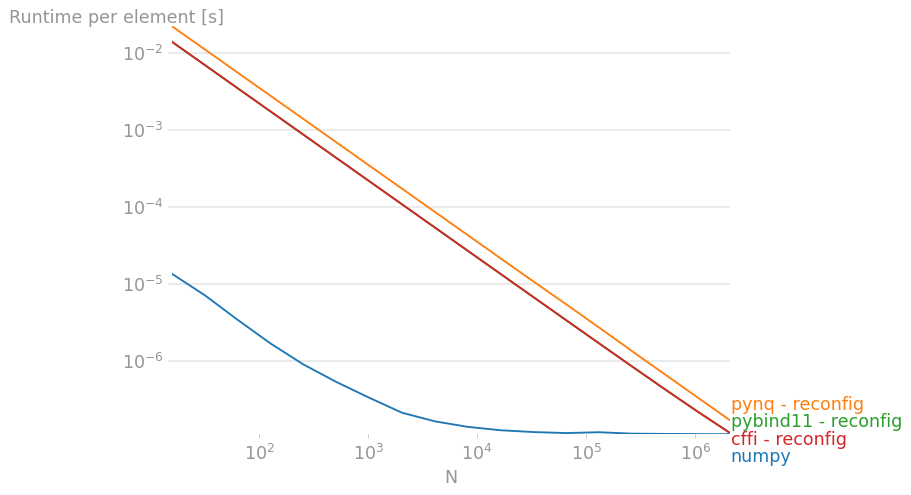

pynq_min_reconf = inf
pybind11_min_reconf = inf
cffi_min_reconf = inf


In [11]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_i4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n,), dtype="i4")

    x1[:] = np.random.rand(*x1.shape)

    return (x1,)

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [subtract_reduce_all_i4_numpy, subtract_reduce_all_i4_pynq, subtract_reduce_all_i4_pybind11, subtract_reduce_all_i4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_i4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## multiply_reduce_all_i4


kernel = numpy, n = 16, t = 0.00020103110000000001
kernel = pynq, n = 16, t = 0.1316447296
kernel = pybind11, n = 16, t = 0.00036497320000000006
kernel = cffi, n = 16, t = 0.0002816815
kernel = numpy, n = 32, t = 0.00021077720000000003
kernel = pynq, n = 32, t = 0.1315013253
kernel = pybind11, n = 32, t = 0.00036665440000000003
kernel = cffi, n = 32, t = 0.0002606802
kernel = numpy, n = 64, t = 0.00021579020000000003
kernel = pynq, n = 64, t = 0.13114325970000001
kernel = pybind11, n = 64, t = 0.0003828775
kernel = cffi, n = 64, t = 0.0002619289
kernel = numpy, n = 128, t = 0.000223739
kernel = pynq, n = 128, t = 0.13143771890000003
kernel = pybind11, n = 128, t = 0.00030205659999999997
kernel = cffi, n = 128, t = 0.0002621397
kernel = numpy, n = 256, t = 0.00023768890000000001
kernel = pynq, n = 256, t = 0.1314475445
kernel = pybind11, n = 256, t = 0.0003019923
kernel = cffi, n = 256, t = 0.0002647883
kernel = numpy, n = 512, t = 0.0002668081
kernel = pynq, n = 512, t = 0.131447718000

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.256444375000000… │ 0.0082277956      │ 2.281082500000000… │ 1.760509375e-05   │
│ 32      │ 6.586787500000001… │ 0.004109416415625 │ 1.145795000000000… │ 8.14625625e-06    │
│ 64      │ 3.371721875000000… │ 0.00204911343281… │ 5.9824609375e-06   │ 4.0926390625e-06  │
│ 128     │ 1.7479609375e-06   │ 0.00102685717890… │ 2.359817187499999… │ 2.04796640625e-06 │
│ 256     │ 9.284722656250001… │ 0.00051346697070… │ 1.179657421875e-06 │ 1.034329296875e-… │
│ 512     │ 5.211095703125e-07 │ 0.00025673382421… │ 7.4348984375e-07   │ 5.23636523437500… │
│ 1024    │ 3.3143505859375e-… │ 0.00012921145917… │ 3.6751767578125e-… │ 2.65881250000000… │
│ 2048    │ 2.203438964843750… │ 6.42825255859375… │ 1.496000488281250… │ 1.35742626953125… │
│ 4096    │ 1.624883056640625… │ 3.21671014404296… │ 1.024846679687500… │ 7.312080078125e-… │
│ 8192    │ 1.382602905273437… │ 1.60948105590820… │ 4.409025878906250… │ 4.17149536132812… │
│ 16384   │ 1.249655395507812… │ 8.04732020263672… │ 2.536200561523437… │ 2.47252502441406… │
│ 32768   │ 1.183420043945312… │ 4.03128513183593… │ 1.789641723632813… │ 1.72709564208984… │
│ 65536   │ 1.144971817016601… │ 2.01605033111572… │ 1.482239074707031… │ 1.31815139770507… │
│ 131072  │ 1.129610374450683… │ 1.00884377136230… │ 1.182591094970703… │ 1.10591140747070… │
│ 262144  │ 1.126615573883056… │ 5.05312932205200… │ 1.057128067016601… │ 1.05360527038574… │
│ 524288  │ 1.117866279602050… │ 2.52669657516479… │ 1.033466224670410… │ 1.02635938644409… │
│ 1048576 │ 1.111879517555236… │ 1.26571334075927… │ 1.014187507629394… │ 1.02254647254943… │
│ 2097152 │ 1.110239457607269… │ 6.33750967979431… │ 1.007851057052612… │ 1.00833609580993… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

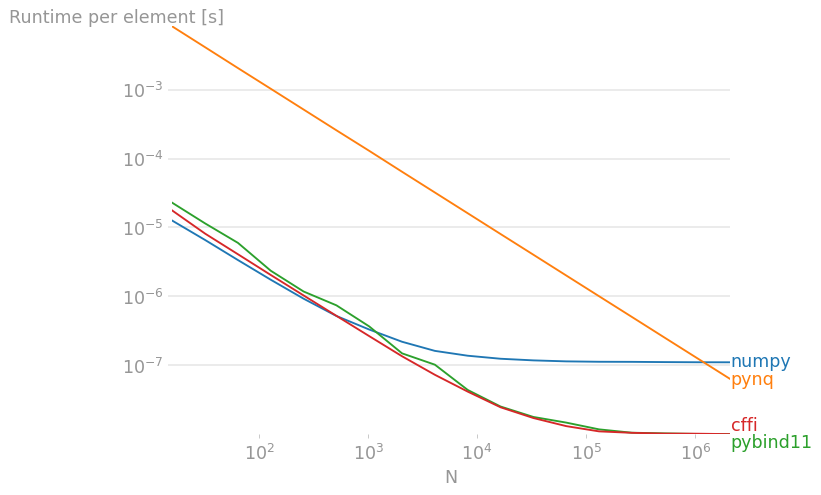

pynq_min = 1048576
pybind11_min = 1024
cffi_min = 512
Bitstream download time = 0.21852269800000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.256444375000000… │ 0.021885464225    │ 0.013680479450000… │ 0.01367527371875  │
│ 32      │ 6.586787500000001… │ 0.01093825072812… │ 0.006840292262500… │ 0.00683698056875… │
│ 64      │ 3.371721875000000… │ 0.00546353058906… │ 0.0034203996171875 │ 0.00341850979531… │
│ 128     │ 1.7479609375e-06   │ 0.00273406575703… │ 0.0017095683953125 │ 0.00170925654453… │
│ 256     │ 9.284722656250001… │ 0.00136707125976… │ 0.000854783946484… │ 0.00085463861835… │
│ 512     │ 5.211095703125e-07 │ 0.00068353596875  │ 0.000427545634375… │ 0.00042732578105… │
│ 1024    │ 3.3143505859375e-… │ 0.00034261253144… │ 0.000213768589941… │ 0.00021366695351… │
│ 2048    │ 2.203438964843750… │ 0.00017098306171… │ 0.000106850136181… │ 0.00010683627875… │
│ 4096    │ 1.624883056640625… │ 8.55173695068359… │ 5.345275273437500… │ 5.34233888671875… │
│ 8192    │ 1.382602905273437… │ 4.27699445922851… │ 2.671922429199218… │ 2.67168489868164… │
│ 16384   │ 1.249655395507812… │ 2.13848872192382… │ 1.336292902221679… │ 1.33622922668457… │
│ 32768   │ 1.183420043945312… │ 1.07000686401367… │ 6.68667992553711e… │ 6.68605446472168… │
│ 65536   │ 1.144971817016601… │ 5.35044208526611… │ 3.349214144897461… │ 3.34757326812744… │
│ 131072  │ 1.129610374450683… │ 2.67603964843750… │ 1.679021788024902… │ 1.67825499114990… │
│ 262144  │ 1.126615573883056… │ 1.33891087074279… │ 8.441692192077638… │ 8.44133991241455… │
│ 524288  │ 1.117866279602050… │ 6.69468626785278… │ 4.271336315155029… │ 4.27062563133239… │
│ 1048576 │ 1.111879517555236… │ 3.34970818710327… │ 2.185413597106933… │ 2.18624949359893… │
│ 2097152 │ 1.110239457607269… │ 1.67574839115142… │ 1.142782528877258… │ 1.14283103275299… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

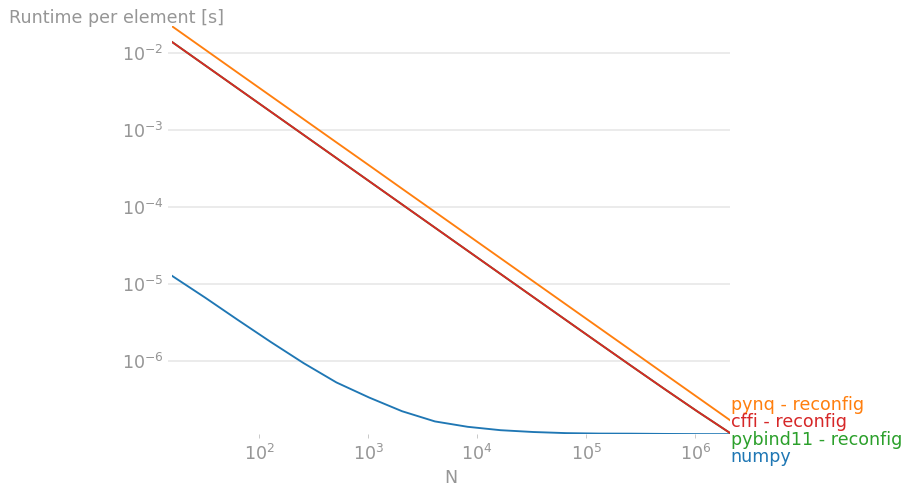

pynq_min_reconf = inf
pybind11_min_reconf = inf
cffi_min_reconf = inf


In [12]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_i4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n, ), dtype="i4")

    x1[:] = np.random.rand(*x1.shape)

    return (x1,)

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [multiply_reduce_all_i4_numpy, multiply_reduce_all_i4_pynq, multiply_reduce_all_i4_pybind11, multiply_reduce_all_i4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_i4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## dot_i4


kernel = numpy, n = 16, t = 0.00018755610000000003
kernel = pynq, n = 16, t = 0.158189402
kernel = pybind11, n = 16, t = 0.0002916563
kernel = cffi, n = 16, t = 0.0002726712
kernel = numpy, n = 32, t = 0.00020089100000000003
kernel = pynq, n = 32, t = 0.1589978699
kernel = pybind11, n = 32, t = 0.0003042612
kernel = cffi, n = 32, t = 0.0002629103
kernel = numpy, n = 64, t = 0.00021744210000000002
kernel = pynq, n = 64, t = 0.1581136157
kernel = pybind11, n = 64, t = 0.00037719880000000003
kernel = cffi, n = 64, t = 0.00027815530000000003
kernel = numpy, n = 128, t = 0.00021286270000000002
kernel = pynq, n = 128, t = 0.15820955750000001
kernel = pybind11, n = 128, t = 0.00037222390000000007
kernel = cffi, n = 128, t = 0.0002688538
kernel = numpy, n = 256, t = 0.0002473837
kernel = pynq, n = 256, t = 0.1582928275
kernel = pybind11, n = 256, t = 0.00037495730000000003
kernel = cffi, n = 256, t = 0.0002691422
kernel = numpy, n = 512, t = 0.00030671820000000005
kernel = pynq, n = 512, t = 0

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.172225625000000… │ 0.009886837625    │ 1.822851875e-05    │ 1.704195e-05      │
│ 32      │ 6.277843750000001… │ 0.004968683434375 │ 9.5081625e-06      │ 8.215946875e-06   │
│ 64      │ 3.397532812500000… │ 0.00247052524531… │ 5.893731250000000… │ 4.34617656250000… │
│ 128     │ 1.662989843750000… │ 0.00123601216796… │ 2.907999218750000… │ 2.1004203125e-06  │
│ 256     │ 9.66342578125e-07  │ 0.00061833135742… │ 1.464676953125000… │ 1.05133671875e-06 │
│ 512     │ 5.990589843750001… │ 0.00030952332519… │ 5.876203125e-07    │ 5.456671875e-07   │
│ 1024    │ 4.0002880859375e-… │ 0.00015481519414… │ 3.86119921875e-07  │ 2.7227587890625e… │
│ 2048    │ 3.165780761718750… │ 7.74202321289062… │ 1.515890625e-07    │ 1.40768896484375… │
│ 4096    │ 3.2570322265625e-… │ 3.87660968505859… │ 8.153388671875e-08 │ 7.35332763671875… │
│ 8192    │ 3.018004394531250… │ 1.95922551635742… │ 5.604301757812500… │ 4.206689453125e-… │
│ 16384   │ 2.900261962890625… │ 1.02187345458984… │ 2.690895385742187… │ 2.54188537597656… │
│ 32768   │ 2.840971588134765… │ 4.84557089538574… │ 1.814211730957031… │ 1.74790618896484… │
│ 65536   │ 2.824955108642578… │ 2.43331410369873… │ 1.492265014648437… │ 1.31975799560546… │
│ 131072  │ 2.797306190490723… │ 1.21544111099243… │ 1.140263519287109… │ 1.10630050659179… │
│ 262144  │ 2.78458708190918e… │ 6.10200358963012… │ 1.062833366394043… │ 1.05775100708007… │
│ 524288  │ 2.773975374221801… │ 3.05522830772399… │ 1.028807239532470… │ 1.02700487136840… │
│ 1048576 │ 2.773763696670532… │ 1.53693850994110… │ 1.015871458053589… │ 1.02465811729431… │
│ 2097152 │ 2.770152158260345… │ 7.75474114418029… │ 1.008229765892028… │ 1.00832872867584… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

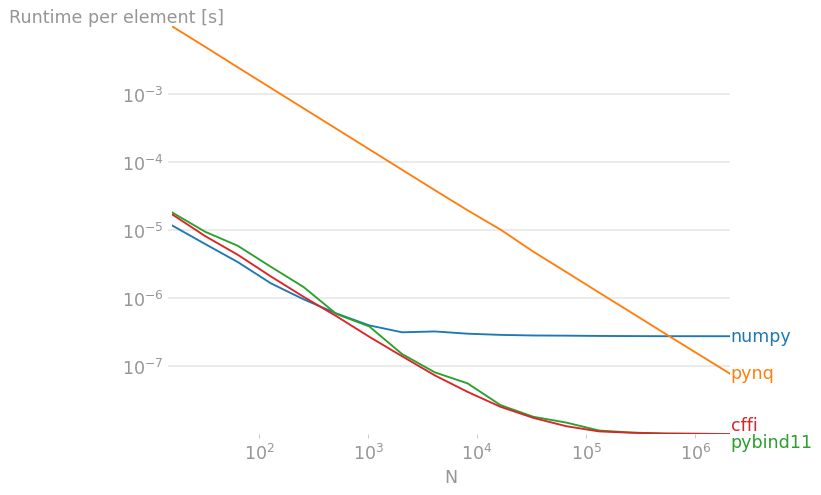

pynq_min = 524288
pybind11_min = 256
cffi_min = 256
Bitstream download time = 0.216869686


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.172225625000000… │ 0.023441193       │ 0.01357258389375   │ 0.013571397325    │
│ 32      │ 6.277843750000001… │ 0.011745861121875 │ 0.00678668585      │ 0.006785393634375 │
│ 64      │ 3.397532812500000… │ 0.00585911408906… │ 0.003394482575     │ 0.00339293502031… │
│ 128     │ 1.662989843750000… │ 0.00293030658984… │ 0.001697202421093… │ 0.00169639484218… │
│ 256     │ 9.66342578125e-07  │ 0.00146547856835… │ 0.000848611887890… │ 0.00084819854765… │
│ 512     │ 5.990589843750001… │ 0.00073309693066… │ 0.000424161225781… │ 0.00042411927265… │
│ 1024    │ 4.0002880859375e-… │ 0.000366601996875 │ 0.000212172922656… │ 0.00021205907861… │
│ 2048    │ 3.165780761718750… │ 0.00018331363349… │ 0.000106044990429… │ 0.00010603417026… │
│ 4096    │ 3.2570322265625e-… │ 9.17127975341796… │ 5.30282345703125e… │ 5.30202339599609… │
│ 8192    │ 3.018004394531250… │ 4.60656055053711… │ 2.6529393359375e-… │ 2.65154172363281… │
│ 16384   │ 2.900261962890625… │ 2.34554097167968… │ 1.326358412475586… │ 1.32620940246582… │
│ 32768   │ 2.840971588134765… │ 1.14639084808349… │ 6.636479702758789… │ 6.63581664733886… │
│ 65536   │ 2.824955108642578… │ 5.74248289642334… │ 3.324091442871094… │ 3.32236637268066… │
│ 131072  │ 2.797306190490723… │ 2.87002550735473… │ 1.665987031555175… │ 1.66564740142822… │
│ 262144  │ 2.78458708190918e… │ 1.43749255714416… │ 8.379205318450928… │ 8.37869708251953… │
│ 524288  │ 2.773975374221801… │ 7.19168929862976… │ 4.239341714859009… │ 4.23916147804260… │
│ 1048576 │ 2.773763696670532… │ 3.60516900539398… │ 2.169817641258239… │ 2.17069630718231… │
│ 2097152 │ 2.770152158260345… │ 1.80958936214447… │ 1.134938224315643… │ 1.13494812059402… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

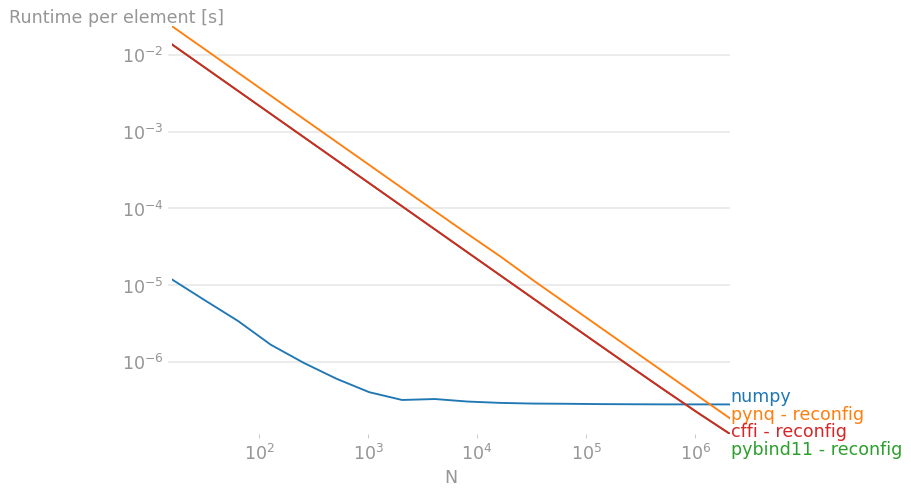

pynq_min_reconf = 1048576
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [13]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_i4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n, ), dtype="i4")
    x2 = allocate(shape=(n, ), dtype="i4")

    x1[:] = np.random.rand(*x1.shape)
    x2[:] = np.random.rand(*x2.shape)

    return x1, x2

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [dot_i4_numpy, dot_i4_pynq, dot_i4_pybind11, dot_i4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_i4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## sum_of_squares_i4


kernel = numpy, n = 16, t = 0.0005213665000000001
kernel = pynq, n = 16, t = 0.131840425
kernel = pybind11, n = 16, t = 0.0002857806
kernel = cffi, n = 16, t = 0.0002620486
kernel = numpy, n = 32, t = 0.00048456240000000004
kernel = pynq, n = 32, t = 0.13123359980000002
kernel = pybind11, n = 32, t = 0.00028539900000000004
kernel = cffi, n = 32, t = 0.0002697727
kernel = numpy, n = 64, t = 0.0005263418000000001
kernel = pynq, n = 64, t = 0.131572837
kernel = pybind11, n = 64, t = 0.0003847433
kernel = cffi, n = 64, t = 0.0002595122
kernel = numpy, n = 128, t = 0.0005204627000000001
kernel = pynq, n = 128, t = 0.1316145453
kernel = pybind11, n = 128, t = 0.0002904997
kernel = cffi, n = 128, t = 0.0002616683
kernel = numpy, n = 256, t = 0.0005248145
kernel = pynq, n = 256, t = 0.1317303638
kernel = pybind11, n = 256, t = 0.00029628740000000003
kernel = cffi, n = 256, t = 0.000260488
kernel = numpy, n = 512, t = 0.0006078358000000001
kernel = pynq, n = 512, t = 0.1315905115
kernel = pybin

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 3.258540625000000… │ 0.0082400265625   │ 1.78612875e-05     │ 1.63780375e-05    │
│ 32      │ 1.514257500000000… │ 0.00410104999375… │ 8.918718750000001… │ 8.430396875e-06   │
│ 64      │ 8.224090625000002… │ 0.002055825578125 │ 6.0116140625e-06   │ 4.054878125e-06   │
│ 128     │ 4.066114843750001… │ 0.00102823863515… │ 2.26952890625e-06  │ 2.04428359375e-06 │
│ 256     │ 2.050056640625e-06 │ 0.00051457173359… │ 1.157372656250000… │ 1.01753125e-06    │
│ 512     │ 1.187179296875000… │ 0.00025701271777… │ 7.322896484375e-07 │ 5.20773046875e-07 │
│ 1024    │ 6.20454296875e-07  │ 0.00012873522871… │ 2.909855468750000… │ 2.6111044921875e… │
│ 2048    │ 3.97640185546875e… │ 6.44101600585937… │ 1.9392880859375e-… │ 1.36544482421874… │
│ 4096    │ 2.678908447265625… │ 3.21577210449218… │ 7.900205078125002… │ 7.2063330078125e… │
│ 8192    │ 2.037818115234375… │ 1.61300641235351… │ 5.352059326171875… │ 4.19251708984375… │
│ 16384   │ 1.70333642578125e… │ 8.04063516235351… │ 3.190125122070312… │ 2.51275146484375… │
│ 32768   │ 1.513761932373046… │ 4.02450544128417… │ 1.803928527832031… │ 1.68272216796875… │
│ 65536   │ 1.463457061767578… │ 2.01272618255615… │ 1.472329406738281… │ 1.32425247192382… │
│ 131072  │ 1.554497802734375… │ 1.01432222900390… │ 1.185107650756836… │ 1.10029838562011… │
│ 262144  │ 1.533668369293213… │ 5.04599246215820… │ 1.056070442199707… │ 1.05350555419921… │
│ 524288  │ 1.508699373245239… │ 2.52602887344360… │ 1.028259906768798… │ 1.02683872222900… │
│ 1048576 │ 1.490452524185180… │ 1.26592825889587… │ 1.015742177963256… │ 1.02168376922607… │
│ 2097152 │ 1.481992019653320… │ 6.35062822818756… │ 1.007593393325805… │ 1.00850460529327… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

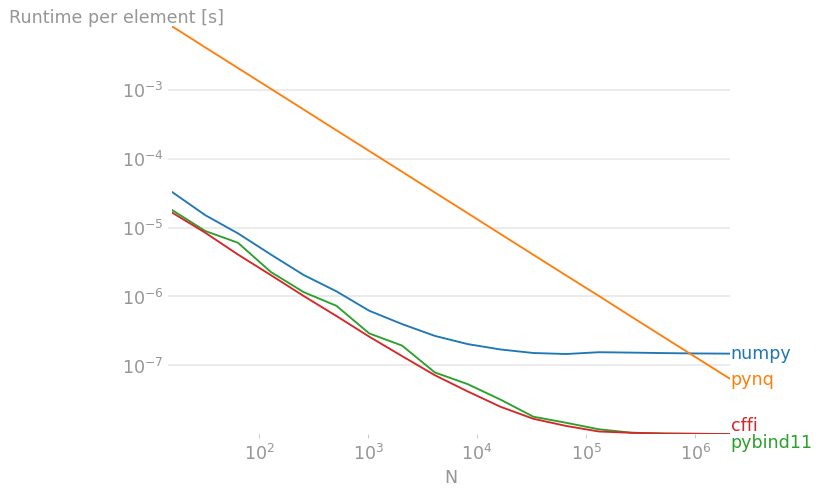

pynq_min = 524288
pybind11_min = 0
cffi_min = 0
Bitstream download time = 0.218354175


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 3.258540625000000… │ 0.0218871625      │ 0.013664997225000… │ 0.01366351397500… │
│ 32      │ 1.514257500000000… │ 0.01092461796250… │ 0.0068324866875    │ 0.00683199836562… │
│ 64      │ 8.224090625000002… │ 0.0054676095625   │ 0.0034177955984375 │ 0.00341583886250… │
│ 128     │ 4.066114843750001… │ 0.00273413062734… │ 0.001708161521093… │ 0.00170793627578… │
│ 256     │ 2.050056640625e-06 │ 0.00136751772968… │ 0.000854103368750… │ 0.00085396352734… │
│ 512     │ 1.187179296875000… │ 0.00068348571582… │ 0.000427205287695… │ 0.00042699377109… │
│ 1024    │ 6.20454296875e-07  │ 0.00034197172773… │ 0.000213527484570… │ 0.00021349760947… │
│ 2048    │ 3.97640185546875e… │ 0.00017102840957… │ 0.000106812178320… │ 0.00010675479399… │
│ 4096    │ 2.678908447265625… │ 8.54668458007812… │ 5.338812680664062… │ 5.33811880859375… │
│ 8192    │ 2.037818115234375… │ 4.27846265014648… │ 2.670808297119140… │ 2.66964875488281… │
│ 16384   │ 1.70333642578125e… │ 2.13679163513183… │ 1.335918244018554… │ 1.33524087036132… │
│ 32768   │ 1.513761932373046… │ 1.06881460357666… │ 6.681679879760743… │ 6.68046781616210… │
│ 65536   │ 1.463457061767578… │ 5.34454647979736… │ 3.346543591308594… │ 3.34506282196044… │
│ 131072  │ 1.554497802734375… │ 2.68023237762451… │ 1.677761225128174… │ 1.67691313247680… │
│ 262144  │ 1.533668369293213… │ 1.33755432052612… │ 8.435157787322998… │ 8.43490129852295… │
│ 524288  │ 1.508699373245239… │ 6.69080424499511… │ 4.267601362228394… │ 4.26745924377441… │
│ 1048576 │ 1.490452524185180… │ 3.34831594467163… │ 2.183961903572082… │ 2.18455606269836… │
│ 2097152 │ 1.481992019653320… │ 1.67625666570663… │ 1.141953182220459… │ 1.14204430341720… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

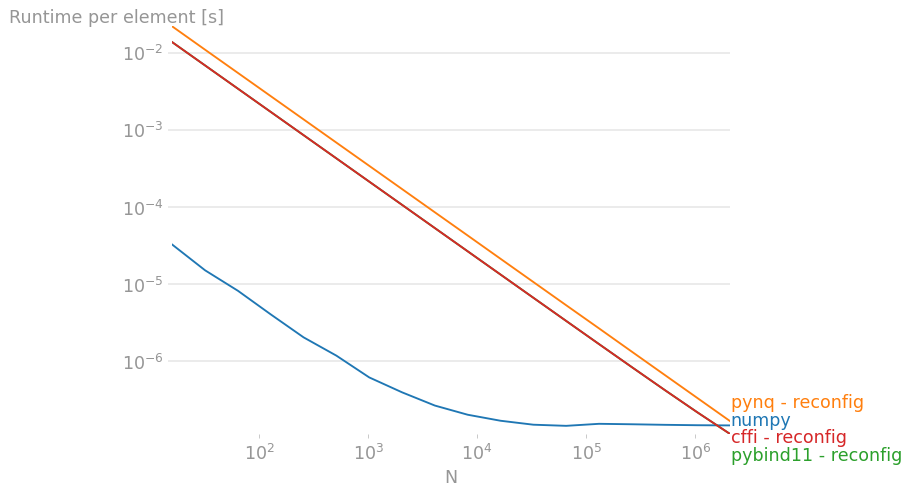

pynq_min_reconf = inf
pybind11_min_reconf = 1048576
cffi_min_reconf = 1048576


In [14]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_i4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n, ), dtype="i4")

    x1[:] = np.random.rand(*x1.shape)

    return (x1,)

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [sum_of_squares_i4_numpy, sum_of_squares_i4_pynq, sum_of_squares_i4_pybind11, sum_of_squares_i4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_i4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## sad_i4


kernel = numpy, n = 16, t = 0.000549007
kernel = pynq, n = 16, t = 0.1629167514
kernel = pybind11, n = 16, t = 0.00035489220000000006
kernel = cffi, n = 16, t = 0.0002654366
kernel = numpy, n = 32, t = 0.0005634674
kernel = pynq, n = 32, t = 0.1574630502
kernel = pybind11, n = 32, t = 0.0003711717
kernel = cffi, n = 32, t = 0.0001392896
kernel = numpy, n = 64, t = 0.0005625665000000001
kernel = pynq, n = 64, t = 0.1580588727
kernel = pybind11, n = 64, t = 0.00029471820000000003
kernel = cffi, n = 64, t = 0.00026759420000000003
kernel = numpy, n = 128, t = 0.0005764612
kernel = pynq, n = 128, t = 0.1581291035
kernel = pybind11, n = 128, t = 0.00029596490000000005
kernel = cffi, n = 128, t = 0.0002666569
kernel = numpy, n = 256, t = 0.0006547572
kernel = pynq, n = 256, t = 0.1581362628
kernel = pybind11, n = 256, t = 0.00037943440000000003
kernel = cffi, n = 256, t = 0.0002777003
kernel = numpy, n = 512, t = 0.0007064926000000001
kernel = pynq, n = 512, t = 0.1583766231
kernel = pybind11

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 3.43129375e-05     │ 0.0101822969625   │ 2.218076250000000… │ 1.65897875e-05    │
│ 32      │ 1.760835625e-05    │ 0.00492072031875  │ 1.1599115625e-05   │ 4.3528e-06        │
│ 64      │ 8.790101562500001… │ 0.00246966988593… │ 4.604971875000000… │ 4.18115937500000… │
│ 128     │ 4.503603125e-06    │ 0.00123538362109… │ 2.312225781250000… │ 2.08325703125e-06 │
│ 256     │ 2.5576453125e-06   │ 0.00061771977656… │ 1.482165625000000… │ 1.084766796875e-… │
│ 512     │ 1.379868359375000… │ 0.00030932934199… │ 7.745515625000001… │ 5.32284179687500… │
│ 1024    │ 8.2297060546875e-… │ 0.0001545738375   │ 3.777298828125e-07 │ 2.77627343750000… │
│ 2048    │ 5.35712109375e-07  │ 7.74996568847656… │ 1.90764404296875e… │ 1.40216650390625… │
│ 4096    │ 4.627041748046875… │ 3.87040328369140… │ 8.306376953125e-08 │ 7.44462158203125… │
│ 8192    │ 3.800459350585937… │ 1.94201434204101… │ 4.609954833984375… │ 4.18271606445312… │
│ 16384   │ 3.502981872558593… │ 9.66787407836914… │ 3.144014892578125… │ 2.63374755859375… │
│ 32768   │ 3.352962066650390… │ 4.84192664794921… │ 2.002660827636719… │ 1.73692626953125… │
│ 65536   │ 3.316990219116211… │ 2.42504310607910… │ 1.364687500000000… │ 1.31964782714843… │
│ 131072  │ 3.455963172912598… │ 1.21296360778808… │ 1.130859375000000… │ 1.12159378051757… │
│ 262144  │ 3.390939022064209… │ 6.07834432983398… │ 1.062579841613769… │ 1.05810806274414… │
│ 524288  │ 3.366988273620606… │ 3.04113056755066… │ 1.029499168395996… │ 1.02807727813720… │
│ 1048576 │ 3.337702584266662… │ 1.53404466819763… │ 1.015009241104126… │ 1.02507285118103… │
│ 2097152 │ 3.331066063404083… │ 7.69906428337097… │ 1.008491849899292… │ 1.00893552780151… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

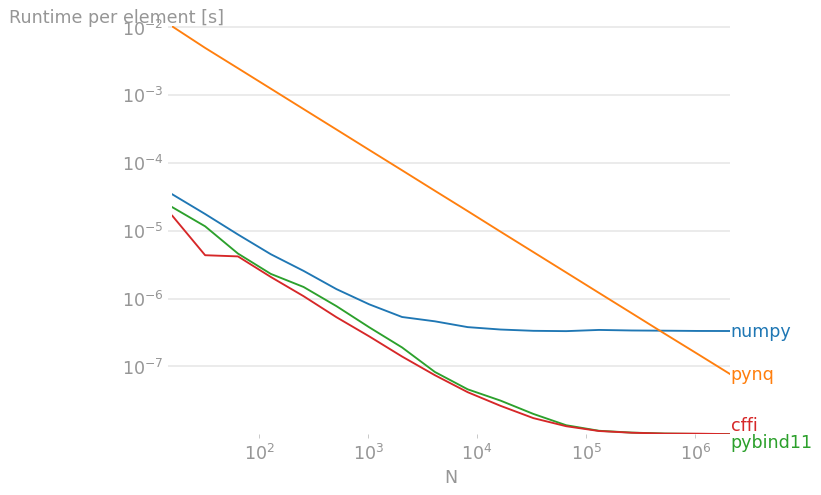

pynq_min = 262144
pybind11_min = 0
cffi_min = 0
Bitstream download time = 0.21964644900000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 3.43129375e-05     │ 0.023910200025    │ 0.013750083825000… │ 0.01374449285000… │
│ 32      │ 1.760835625e-05    │ 0.01178467185000… │ 0.006875550646875… │ 0.00686830433125… │
│ 64      │ 8.790101562500001… │ 0.00590164565156… │ 0.0034365807375    │ 0.00343615692500… │
│ 128     │ 4.503603125e-06    │ 0.00295137150390… │ 0.001718300108593… │ 0.00171807113984… │
│ 256     │ 2.5576453125e-06   │ 0.00147571371796… │ 0.000859476107031… │ 0.00085907870820… │
│ 512     │ 1.379868359375000… │ 0.00073832631269… │ 0.000429771522265… │ 0.00042952925488… │
│ 1024    │ 8.2297060546875e-… │ 0.00036907232285… │ 0.000214876215234… │ 0.00021477611269… │
│ 2048    │ 5.35712109375e-07  │ 0.00018474889956… │ 0.000107440007080… │ 0.00010738945932… │
│ 4096    │ 4.627041748046875… │ 9.23286541748046… │ 5.370768510742188… │ 5.36990675537109… │
│ 8192    │ 3.800459350585937… │ 4.62324540893554… │ 2.685841021728515… │ 2.68541378295898… │
│ 16384   │ 3.502981872558593… │ 2.30740294128418… │ 1.343759548339843… │ 1.34324928100585… │
│ 32768   │ 3.352962066650390… │ 1.15450043151855… │ 6.723104275512696… │ 6.72044692993164… │
│ 65536   │ 3.316990219116211… │ 5.77658193969726… │ 3.365185708618164… │ 3.36473531188964… │
│ 131072  │ 3.455963172912598… │ 2.88873302459716… │ 1.687078010559082… │ 1.68698535461425… │
│ 262144  │ 3.390939022064209… │ 1.44571914138793… │ 8.485105068206788… │ 8.48465789031982… │
│ 524288  │ 3.366988273620606… │ 7.23055410957336… │ 4.292373458862305… │ 4.29223126983642… │
│ 1048576 │ 3.337702584266662… │ 3.62875643920898… │ 2.196212695121765… │ 2.19721905612945… │
│ 2097152 │ 3.331066063404083… │ 1.81726231384277… │ 1.148205070495605… │ 1.14824943828582… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

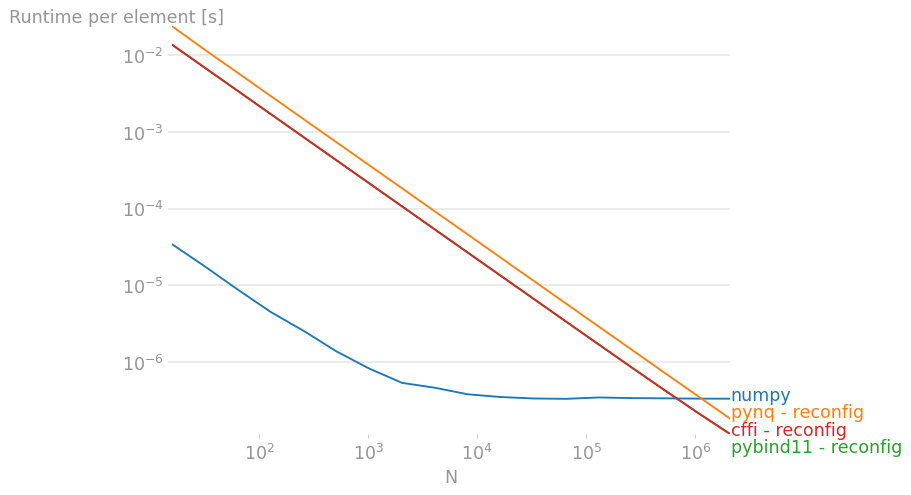

pynq_min_reconf = 1048576
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [15]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_i4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n, ), dtype="i4")
    x2 = allocate(shape=(n, ), dtype="i4")

    x1[:] = np.random.rand(*x1.shape)
    x2[:] = np.random.rand(*x2.shape)

    return x1, x2

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [sad_i4_numpy, sad_i4_pynq, sad_i4_pybind11, sad_i4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_i4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")